# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [30]:
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

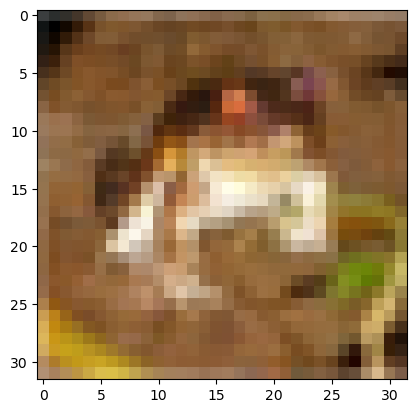

In [31]:
# data loading
cifar_sample = np.load("resources/cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = \text{???} $  

$ \hspace{140px} H_o = \text{???} $  

$ \hspace{140px} W_o = \text{???} $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="https://raw.githubusercontent.com/gmum/ml2022-23/main/lab/resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [32]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape 
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = (img_height-filter_size+(2*padding))//stride + 1
    out_width = (img_width-filter_size+(2*padding))//stride + 1
    out_channels = n_filters
    output = torch.zeros(out_channels,out_height,out_width)
    image_pad = torch.zeros(img_channels,img_height + 2*padding,img_width+2*padding)
    image_pad[:,padding:img_height+padding,padding:img_width+padding] = image
    # your code here
    for n in range(out_channels):
        for j in range(out_height):
            for i in range(out_width):
                output[n,j,i] = torch.sum(filters[n]*image_pad[:,j*stride:j*stride+filter_size,i*stride:i*stride+filter_size]) + bias[n]
    return output

In [33]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [34]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # calculate the dimensions of the output image
    out_height = (img_height-kernel_size + 2*padding)//stride + 1 
    out_width = (img_width-kernel_size + 2*padding)//stride + 1 
    out_channels = img_channels
    out_image = torch.zeros(out_channels,out_height,out_width)
    # your code here
    image_pad = torch.zeros(img_channels,img_height + 2*padding,img_width+2*padding)
    image_pad[:,padding:img_height+padding,padding:img_width+padding] = image
    for n in range(out_channels):
        for j in range(out_height):
            for i in range(out_width):
                out_image[n,j,i] = torch.max(image_pad[n,j*stride:j*stride+kernel_size,i*stride:i*stride+kernel_size])
    return out_image

In [35]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [36]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


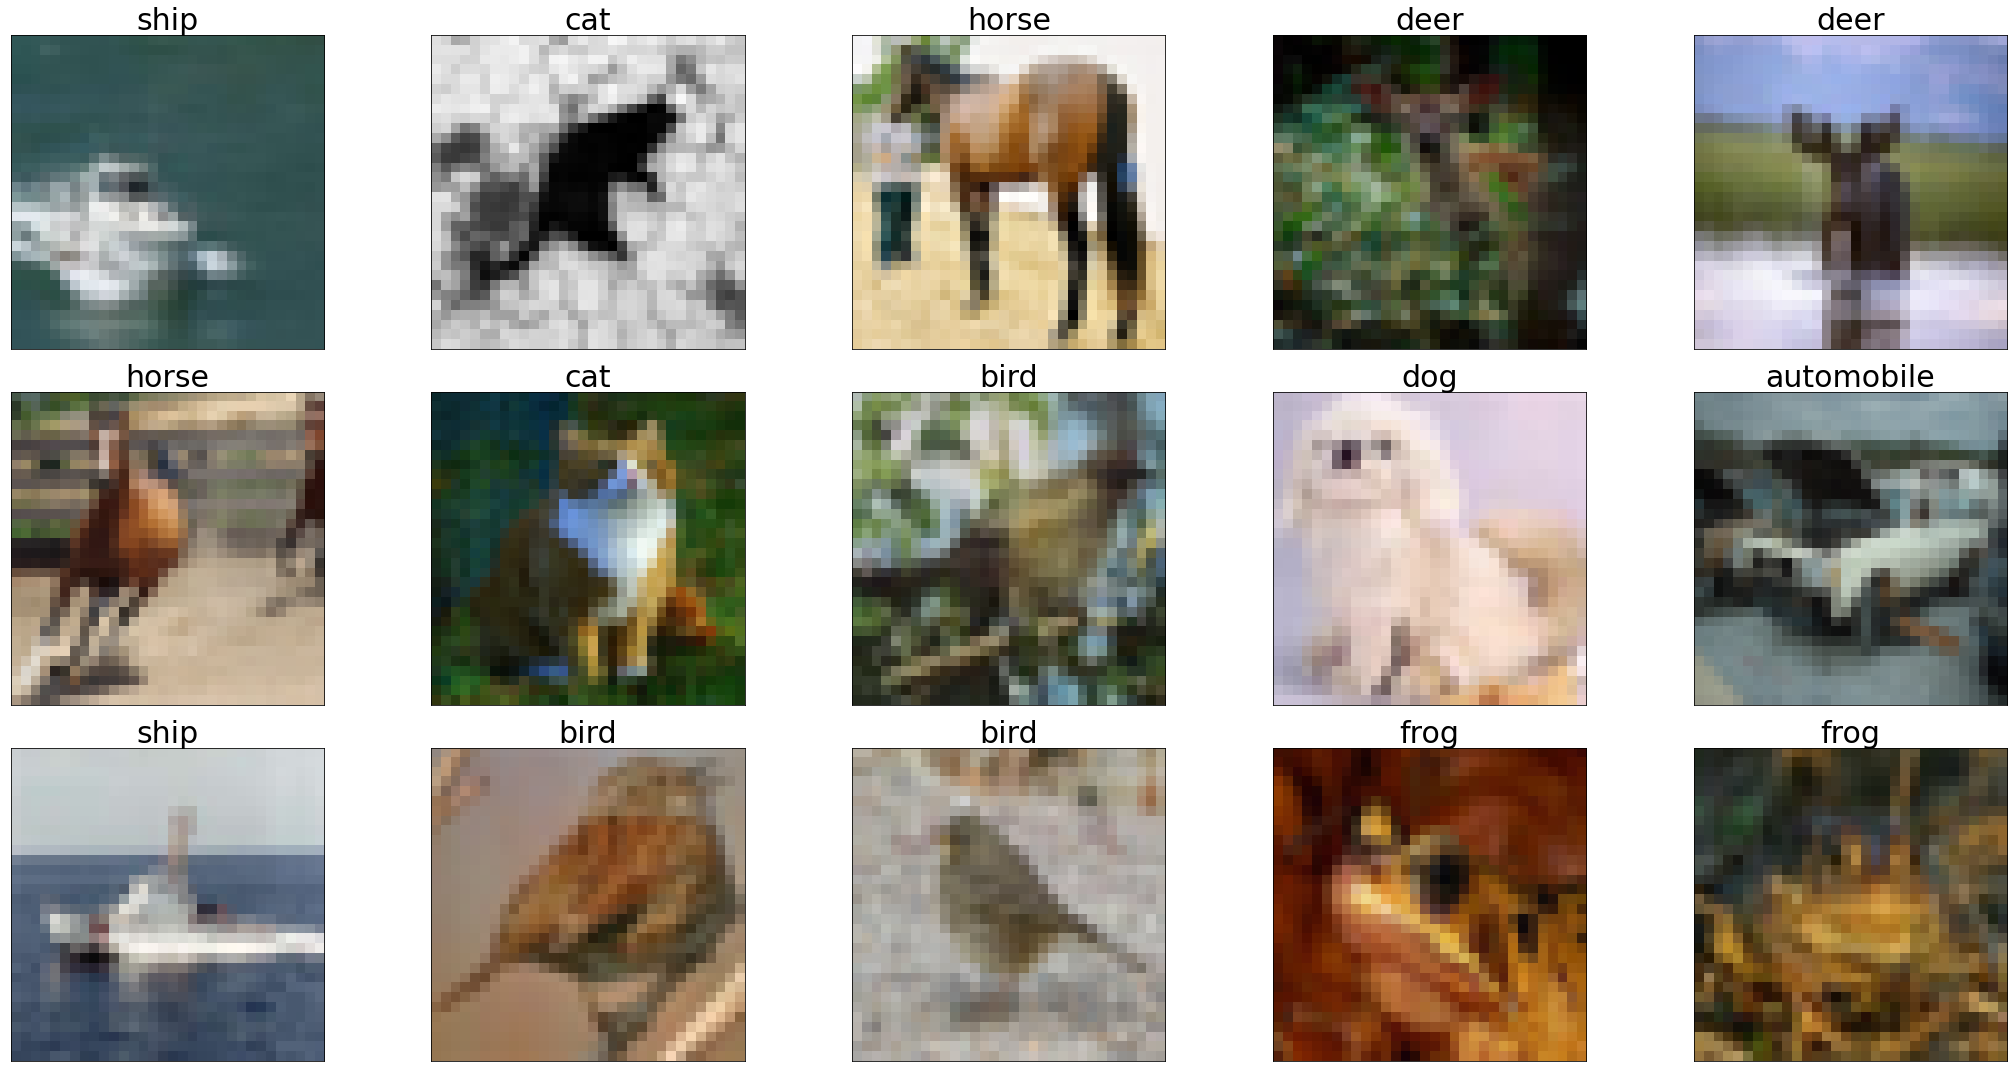

In [ ]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [15]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
class Model(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.mod = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,50,3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(50,100,3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(100,150,3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(150,200,3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(200,300,3),
        torch.nn.ReLU(),
        torch.nn.Flatten(),
        torch.nn.Linear(300,60),
        torch.nn.BatchNorm1d(60),
        torch.nn.ReLU(),
        torch.nn.Linear(60,30),
        torch.nn.BatchNorm1d(30),
        torch.nn.ReLU(),
        torch.nn.Linear(30,10)
    )
  def forward(self,x):
    logits = self.mod(x)
    return logits

model = Model()


In [16]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=ToTensor())

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=ToTensor())


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
for e in range(3):
  correct: int = 0
  for i,(x,y) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()
    if (i + 1) % 100 == 0:
      print("Epoch", e, "iter", (i + 1),"/",len(train_dataset) // 100, "loss:", loss.item(),)
    A = torch.argmax(output,dim=1)
    B = A[A == y]
    correct += len(B)
  print("Train accuracy: ",(100*correct)/len(train_dataset),'%')
  with torch.no_grad():
          correct: int = 0
          for i, (x, y) in enumerate(test_loader):
              output = model(x)
              A = torch.argmax(output,dim=1)
              B = A[A == y]
              correct += len(B)
              print("iter",i + 1,'/',len(test_dataset)//5000,"Test loss: ",criterion(output,y).item())
          print("Test accuracy:", (100*correct) / len(test_dataset),'%')


Epoch 0 iter 100 / 500 loss: 0.7578724026679993
Epoch 0 iter 200 / 500 loss: 0.6941162943840027
Epoch 0 iter 300 / 500 loss: 0.7501642107963562
Epoch 0 iter 400 / 500 loss: 0.8253312110900879
Epoch 0 iter 500 / 500 loss: 0.7216244339942932
Train accuracy:  74.846 %
iter 1 / 2 Test loss:  0.5074703097343445
iter 2 / 2 Test loss:  0.5040189623832703
Test accuracy: 82.98 %
Epoch 1 iter 100 / 500 loss: 0.7213257551193237
Epoch 1 iter 200 / 500 loss: 0.7307183146476746
Epoch 1 iter 300 / 500 loss: 0.7455209493637085
Epoch 1 iter 400 / 500 loss: 0.7504236698150635
Epoch 1 iter 500 / 500 loss: 0.6472048163414001
Train accuracy:  74.814 %
iter 1 / 2 Test loss:  0.5290069580078125
iter 2 / 2 Test loss:  0.5084095597267151
Test accuracy: 82.56 %
Epoch 2 iter 100 / 500 loss: 0.5532367825508118
Epoch 2 iter 200 / 500 loss: 0.537104606628418
Epoch 2 iter 300 / 500 loss: 0.7830071449279785
Epoch 2 iter 400 / 500 loss: 0.7423479557037354
Epoch 2 iter 500 / 500 loss: 0.9130131006240845
Train accuracy:

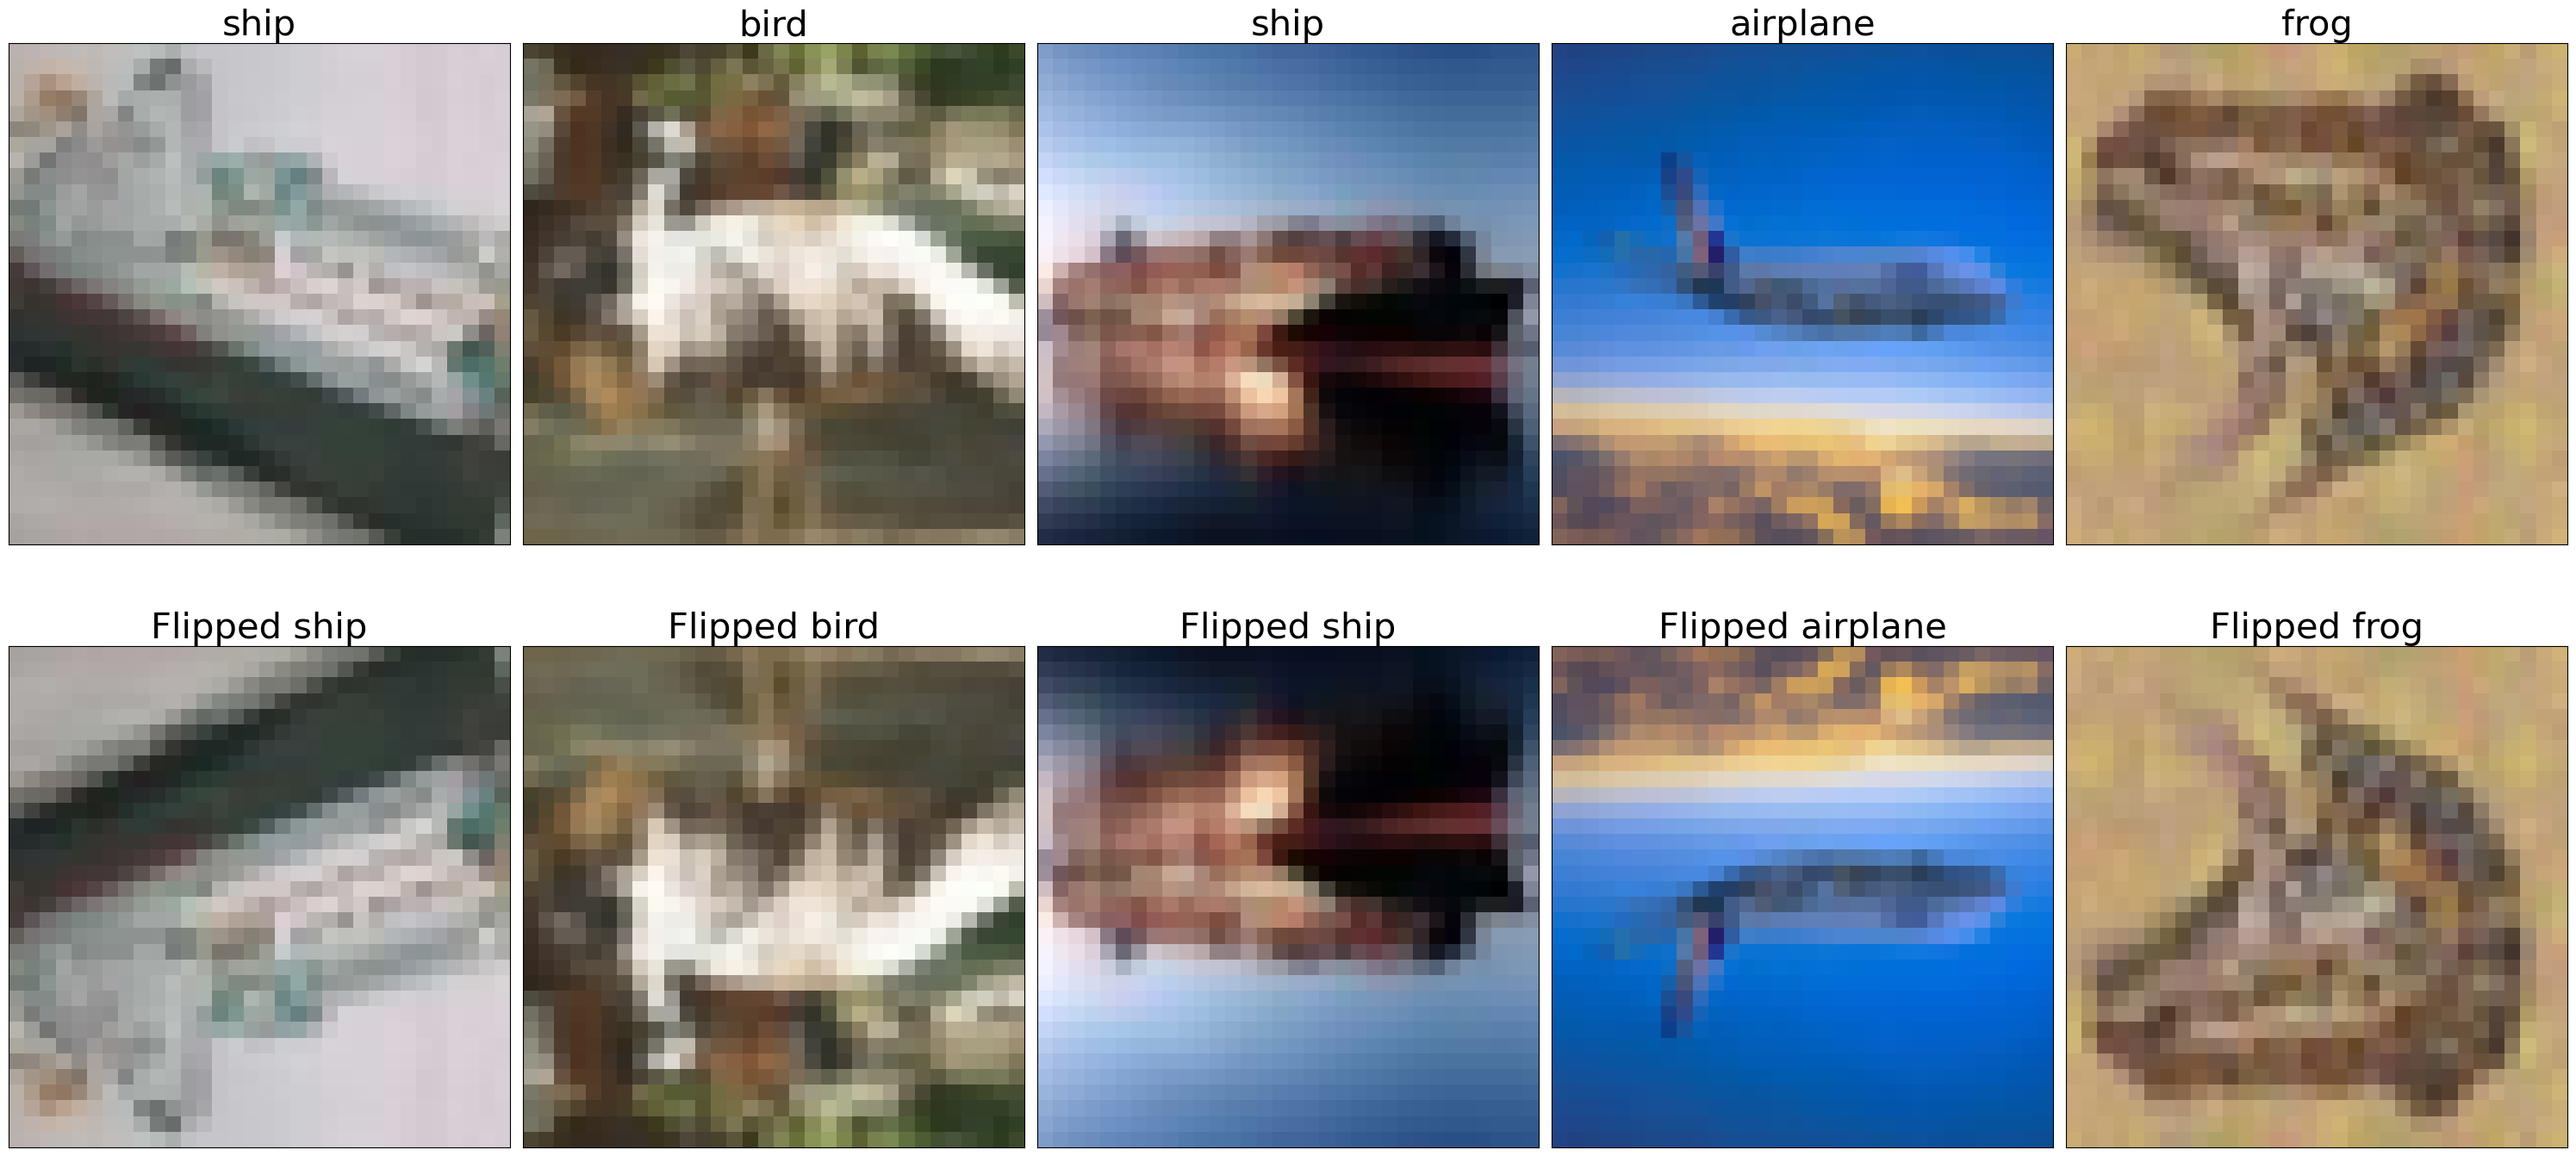

In [6]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [23]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
import torchvision.transforms
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32,padding=4),
                                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                                  torchvision.transforms.RandomRotation(degrees=30),
                                                                  torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                                                  torchvision.transforms.RandomPerspective(),
                                                                  ToTensor()
                                                                  ]))

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=ToTensor())


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified
